<center>
<h2>Fraud Analytics: Assignment-1 </h2>
<h3>TrustRank Algorithm for Fraud Detection in Payment Networks Using Pregel Framework </h3>
</center>

-------

Team Members:-
#### Sakshi Badole : CS24MTECH11008 
#### Laveena Herman : CS24MTECH11010 
#### S Anjana Shankar : CS24MTECH14015
------

### 1. Import Required Libraries

In [1]:
import collections
import threading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Base Classes for Pregel Model

### 2.1 Vertex Class
The fundamental unit in our graph computation model

In [2]:
class Vertex:
    """Vertex in the Pregel computation model, with TrustRank algorithm."""
    def __init__(self, id, value, out_vertices=None, out_weights=None, is_seed=False, total_seed_count=1):
        self.id = id
        self.value = value
        self.out_vertices = out_vertices or []
        self.out_weights = out_weights or []  # Added weights for outgoing edges
        self.incoming_messages = []
        self.outgoing_messages = []
        self.active = True
        self.superstep = 0
        self.is_seed = is_seed
        self.is_sink = True
        self.total_seed_count = total_seed_count
    
    def update(self):
        """Updates the distrust score of this vertex."""
        alpha = 0.85  # Damping factor
        
        if self.superstep == 0:
            self.propagate_scores()
        elif self.superstep < 100:  # Max iterations
            propagation_score = sum(score for (_, score) in self.incoming_messages) if self.incoming_messages else 0
            damped_score = alpha * propagation_score
            teleport_score = (1.0 - alpha) / self.total_seed_count if self.is_seed else 0
            
            self.value = damped_score + teleport_score
            self.propagate_scores()
        else:
            self.active = False
    
    def propagate_scores(self):
        """Propagate scores to outgoing vertices based on weighted edges."""
        self.outgoing_messages = []
        
        if not self.out_vertices:
            return  # Sink nodes handled in EnhancedPregel.redistribute_messages
        
        # Get total outgoing weight
        total_weight = sum(self.out_weights)
        
        if total_weight > 0:
            # Distribute score proportionally to edge weights
            self.outgoing_messages = [
                (vertex, self.value * (weight / total_weight)) 
                for vertex, weight in zip(self.out_vertices, self.out_weights)
            ]
        else:
            # If all weights are zero, distribute equally
            score_per_edge = self.value / len(self.out_vertices)
            self.outgoing_messages = [(vertex, score_per_edge) for vertex in self.out_vertices]


### 2.2 Worker Class
Handles parallel processing of vertices

In [3]:
class Worker(threading.Thread):
    """Worker thread that processes vertices in a superstep."""
    def __init__(self, vertices):
        threading.Thread.__init__(self)
        self.vertices = vertices

    def run(self):
        for vertex in self.vertices:
            if vertex.active:
                vertex.update()

### 2.3 Pregel Class
The main computation framework that coordinates workers and handles message passing

In [4]:
class Pregel:
    """Pregel implementation for TrustRank with sink node handling."""
    def __init__(self, vertices, num_workers):
        self.vertices = vertices
        self.num_workers = num_workers
        self.seed_vertices = [v for v in vertices if v.is_seed]
        self.sink_vertices = [v for v in vertices if v.is_sink]
        self.has_sinks = len(self.sink_vertices) > 0
        
    def run(self, max_iterations=100):
        """Runs the Pregel instance until convergence or max iterations."""
        current_iteration = 0
        
        while self.check_active() and current_iteration < max_iterations:
            self.superstep()
            self.redistribute_messages()
            current_iteration += 1
            
            # if current_iteration % 10 == 0 or current_iteration == max_iterations - 1:
        total_score = sum(v.value for v in self.vertices)
        print(f"Iteration {current_iteration}: Sum of scores = {total_score:.6f}")
        
        # Only normalize after all iterations are complete
        self.normalize_final_scores()
    
    def partition_vertices(self):
        """Partitions vertices among workers."""
        partition = collections.defaultdict(list)
        for vertex in self.vertices:
            partition[hash(vertex) % self.num_workers].append(vertex)
        return partition

    def superstep(self):
        """Executes a single superstep across workers."""
        workers = []
        for vertex_list in self.partition_vertices().values():
            worker = Worker(vertex_list)
            workers.append(worker)
            worker.start()
        for worker in workers:
            worker.join()

    def redistribute_messages(self):
        """Redistributes messages between vertices after a superstep."""
        for vertex in self.vertices:
            vertex.superstep += 1
            vertex.incoming_messages = []

        if self.has_sinks and self.seed_vertices:
            # For sink nodes, redistribute their value equally to seed nodes
            for sink in self.sink_vertices:
                for seed in self.seed_vertices:
                    seed.incoming_messages.append((sink, sink.value / len(self.seed_vertices)))
        
        for vertex in self.vertices:
            for (receiving_vertex, message) in vertex.outgoing_messages:
                receiving_vertex.incoming_messages.append((vertex, message))

    def check_active(self):
        """Checks if any vertices are still active."""
        return any(vertex.active for vertex in self.vertices)

    def normalize_final_scores(self):
        """Ensures the final scores sum to 1.0 by distributing any difference to seed nodes."""
        total_score = sum(vertex.value for vertex in self.vertices)
        print(f"Final sum before normalization: {total_score:.6f}")
        
        if abs(total_score - 1.0) > 0.01:
            difference = 1.0 - total_score
            
            if difference != 0 and self.seed_vertices:
                print(f"Distributing difference of {difference:.6f} to {len(self.seed_vertices)} seed nodes")
                # Distribute the difference equally among seed nodes
                seed_adjustment = difference / len(self.seed_vertices)
                for vertex in self.seed_vertices:
                    vertex.value += seed_adjustment
            elif total_score > 0:
                # Fallback to standard normalization if no seed nodes exist
                print("No seed nodes found. Using standard normalization.")
                for vertex in self.vertices:
                    vertex.value /= total_score
            elif self.seed_vertices:
                # If total score is 0 but we have seed nodes, distribute equally
                print("Total score is 0. Distributing scores equally among seed nodes.")
                seed_value = 1.0 / len(self.seed_vertices)
                for vertex in self.vertices:
                    vertex.value = seed_value if vertex.is_seed else 0.0
            
            # Verify final normalization
            new_total = sum(v.value for v in self.vertices)
            print(f"Post-normalization sum: {new_total:.6f}")


## 3. Data Processing Functions

### 3.1 Data Loading

In [5]:
def load_data():
    """Loads payment data and bad sender list."""
    payments_df = pd.read_excel("Payments.xlsx")
    bad_senders_df = pd.read_excel("bad_sender.xlsx")
    return payments_df, bad_senders_df

### 3.2 Graph Construction

In [6]:
def build_graph(payments_df, bad_senders_df):
    """Builds the graph from payment data using payment amounts as edge weights."""
    all_entities = list(set(payments_df['Sender'].unique()).union(set(payments_df['Receiver'].unique())))
    entity_to_idx = {entity: idx for idx, entity in enumerate(all_entities)}
    
    bad_senders = set(bad_senders_df['Bad Sender'].values)
    seed_count = sum(1 for entity in all_entities if entity in bad_senders)
    
    if seed_count == 0:
        print("Warning: No seed nodes found. Using first entity as seed.")
        seed_count = 1
        bad_senders.add(all_entities[0])
    
    initial_seed_value = 1.0 / seed_count
    
    # Create vertices
    vertices = [
        Vertex(
            entity_to_idx[entity], 
            initial_seed_value if entity in bad_senders else 0.0, 
            is_seed=entity in bad_senders,
            total_seed_count=seed_count
        ) for entity in all_entities
    ]
    
    # Create edge maps first (to aggregate multiple transactions between same entities)
    edge_maps = {}
    for _, row in payments_df.iterrows():
        sender_idx = entity_to_idx[row['Sender']]
        receiver_idx = entity_to_idx[row['Receiver']]
        amount = float(row['Amount'])
        
        # In TrustRank, edges flow backward from receiver to sender
        edge_key = (receiver_idx, sender_idx)
        
        if edge_key in edge_maps:
            edge_maps[edge_key] += amount
        else:
            edge_maps[edge_key] = amount
    
    # Add aggregated edges to vertices
    for (from_idx, to_idx), weight in edge_maps.items():
        vertices[from_idx].out_vertices.append(vertices[to_idx])
        vertices[from_idx].out_weights.append(weight)
        vertices[from_idx].is_sink = False
    
    # Print some statistics about the edges
    edge_counts = collections.Counter(len(v.out_vertices) for v in vertices)
    total_edges = sum(edge_counts[count] * count for count in edge_counts)
    
    graph_stats = {
        'Total Nodes': len(vertices),
        'Seed Nodes': seed_count,
        'Total Edges': total_edges,
        'Sink Nodes': sum(1 for v in vertices if v.is_sink),
        'Edges with Zero Weight': sum(1 for v in vertices for w in v.out_weights if w == 0)
    }
    
    return vertices, entity_to_idx, graph_stats

### 3.3 Running the TrustRank Algorithm

In [7]:
def run_trustrank(num_workers=4):
    """Runs the TrustRank algorithm and returns results."""
    payments_df, bad_senders_df = load_data()
    vertices, entity_to_idx, stats = build_graph(payments_df, bad_senders_df)
    
    print("\nGraph Statistics:")
    for stat, value in stats.items():
        print(f"{stat}: {value}")
    
    pregel = Pregel(vertices, num_workers)
    pregel.run()
    
    total_score = sum(vertex.value for vertex in vertices)
    print(f"\nFinal sum of scores: {total_score:.6f}")
    print(f"Normalization CHECK: {'PASSED ✓' if abs(total_score - 1.0) < 0.01 else 'FAILED ✗'}")
    
    # Create result DataFrame
    idx_to_entity = {idx: entity for entity, idx in entity_to_idx.items()}
    results = [{
        'Entity': idx_to_entity[v.id],
        'DistrustScore': v.value,
        'IsSeed': v.is_seed,
        'IsSink': v.is_sink,
        # 'OutDegree': len(v.out_vertices),
        # 'TotalOutWeight': sum(v.out_weights) if v.out_weights else 0
    } for v in vertices]
    
    result_df = pd.DataFrame(results).sort_values('DistrustScore', ascending=False)
    return result_df

## 4. Analysis and Visualization Functions

### 4.1 Identify Potential Bad Senders

In [8]:
def identify_potential_bad_senders(result_df):
    """Identifies potential bad senders using percentile thresholds."""
    # Check if we have seed nodes
    if sum(result_df['IsSeed']) == 0:
        print("No known bad senders (seed nodes) found.")
        return None
    
    # Use percentile-based thresholds
    non_seed_df = result_df[~result_df['IsSeed']]
    percentile_90 = non_seed_df['DistrustScore'].quantile(0.90)
    percentile_95 = non_seed_df['DistrustScore'].quantile(0.95)
    
    high_score_90 = non_seed_df[non_seed_df['DistrustScore'] >= percentile_90]
    high_score_95 = non_seed_df[non_seed_df['DistrustScore'] >= percentile_95]
    
    print(f"\n90th percentile threshold: {percentile_90:.6f} ({len(high_score_90)} entities)")
    print(f"95th percentile threshold: {percentile_95:.6f} ({len(high_score_95)} entities)")
    
    return {
        'p90': {'threshold': percentile_90, 'entities': high_score_90, 'label': '90th Percentile'},
        'p95': {'threshold': percentile_95, 'entities': high_score_95, 'label': '95th Percentile'}
    }


### 4.2 Visualization Functions

In [9]:
def create_visualizations(result_df, threshold_results):
    """Creates visualizations with scatter plot, CDF, and basic log-scale histogram."""
    sns.set(style="whitegrid")
    
    # 1. Scatter plot of entities
    plt.figure(figsize=(12, 8))
    top_n = min(700, len(result_df))
    top_entities = result_df.nlargest(top_n, 'DistrustScore')
    
    x = np.random.normal(0, 0.1, size=len(top_entities))
    colors = ['red' if is_seed else 'blue' for is_seed in top_entities['IsSeed']]
    plt.scatter(x, top_entities['DistrustScore'], c=colors, alpha=0.7)
    
    # Add threshold lines
    for method, data in threshold_results.items():
        plt.axhline(y=data['threshold'], color='green', linestyle='--', 
                   alpha=0.5, label=f"{data['label']}: {data['threshold']:.6f}")
    
    plt.xticks([])
    plt.title('Top Entities by Distrust Score', fontsize=15)
    plt.ylabel('Distrust Score', fontsize=12)
    
    # Add color legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Known Bad Sender'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Other Entity')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    plt.tight_layout()
    plt.savefig('distrust_scatter.png')
    
    # 2. CDF Plot
    plt.figure(figsize=(12, 6))
    sorted_scores = np.sort(result_df['DistrustScore'])
    cdf = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores)
    plt.plot(sorted_scores, cdf, label='CDF')
    
    for method, data in threshold_results.items():
        plt.axvline(x=data['threshold'], color='red', linestyle='--', 
                   alpha=0.5, label=f"{data['label']}: {data['threshold']:.6f}")
    
    plt.title('Cumulative Distribution of Distrust Scores', fontsize=15)
    plt.xlabel('Distrust Score', fontsize=12)
    plt.ylabel('Cumulative Probability', fontsize=12)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('distrust_cdf.png')
    
    # histogram
    plt.figure(figsize=(14, 8))
    
    # Filter out zeros for log scale
    non_zero_scores = result_df[result_df['DistrustScore'] > 0]['DistrustScore']
    
    if len(non_zero_scores) > 0:
        # Create a better binning strategy
        # Calculate min and max on log scale
        min_val = np.log10(non_zero_scores.min())
        max_val = np.log10(non_zero_scores.max())
        
        # Create bins that are evenly spaced in log space
        log_bins = np.logspace(min_val, max_val, 40)
        
        # Create histogram with improved parameters
        plt.hist(non_zero_scores, bins=log_bins, alpha=0.8, color='steelblue', 
                 edgecolor='black', linewidth=0.5)
        plt.xscale('log')
        plt.yscale('log')
        
        # Set x-axis to show tick marks at meaningful intervals
        # This creates tick marks at each power of 10
        plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0e}" if x < 0.001 else f"{x:.4f}"))
        
        # Add vertical lines for thresholds with improved visibility
        for method, data in threshold_results.items():
            plt.axvline(x=data['threshold'], color='red', linestyle='--', linewidth=2,
                       alpha=0.8, label=f"{data['label']}: {data['threshold']:.6f}")
        
        # Add text labels directly on plot for thresholds
        for method, data in threshold_results.items():
            # Position the text slightly offset from the line for visibility
            text_x = data['threshold'] * 1.1
            plt.text(text_x, plt.ylim()[1]*0.5, f"{data['label']}: {data['threshold']:.6f}", 
                    rotation=90, verticalalignment='center', color='darkred', fontweight='bold')
        
        # Add a grid that respects the log scale
        plt.grid(True, which="both", ls="-", alpha=0.2)
        
        # Labels and title
        plt.title('Distribution of Distrust Scores (Log Scale)', fontsize=16, fontweight='bold')
        plt.xlabel('Distrust Score (Log Scale)', fontsize=14)
        plt.ylabel('Count (Log Scale)', fontsize=14)
        
        # Add a more descriptive legend
        plt.legend(loc='upper right', framealpha=0.9)
        
        # Add annotations for data context
        plt.annotate(f"Total entities: {len(result_df)}", xy=(0.02, 0.95), xycoords='axes fraction',
                    fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="purple", alpha=0.8))
        
        # Ensure enough margins and tight layout
        plt.tight_layout()
        plt.savefig('improved_distrust_histogram_log.png', dpi=300)
        print("Improved histogram saved as 'improved_distrust_histogram_log.png'")
    else:
        print("Warning: No non-zero scores for log-scale histogram")
    


## 5. Main Function

In [10]:
def main():
    """Main function to run TrustRank algorithm and analyze results."""
    print("Running TrustRank on payment network with transaction amount weighting...")
    result_df = run_trustrank()
    
    # Print top potentially malicious entities
    print("\nTop potentially malicious entities:")
    print(result_df.head(20))
    
    # Print known bad senders stats
    seed_results = result_df[result_df['IsSeed']]
    print(f"\nNumber of known bad senders: {len(seed_results)}")
    if not seed_results.empty:
        print("Known bad senders and their scores:")
        print(seed_results)
    
    # Identify potential bad senders
    threshold_results = identify_potential_bad_senders(result_df)
    
    # Create visualizations if we have threshold results
    if threshold_results:
        create_visualizations(result_df, threshold_results)
        
        # Save results to Excel
        result_df.to_excel("trustrank_results.xlsx", index=False)
        
        # Save potential bad senders
        with pd.ExcelWriter("potential_bad_senders.xlsx") as writer:
            for method, data in threshold_results.items():
                new_entities = data['entities'][~data['entities']['IsSeed']]
                new_entities.to_excel(writer, sheet_name=method, index=False)
        
        print("\nResults saved to Excel files")

## 6. Entry Point

Running TrustRank on payment network with transaction amount weighting...

Graph Statistics:
Total Nodes: 799
Seed Nodes: 20
Total Edges: 5358
Sink Nodes: 428
Edges with Zero Weight: 0
Iteration 100: Sum of scores = 1.000000
Final sum before normalization: 1.000000

Final sum of scores: 1.000000
Normalization CHECK: PASSED ✓

Top potentially malicious entities:
     Entity  DistrustScore  IsSeed  IsSink
261    1210       0.051023    True   False
99     1042       0.047537    True   False
143    1086       0.040072   False   False
91     1034       0.037962    True   False
610    1668       0.034514    True    True
202    1147       0.027628    True   False
155    1099       0.027456    True   False
306    1259       0.027143    True    True
64     1007       0.026547    True   False
304    1256       0.026345    True    True
381    1344       0.024102   False    True
421    1393       0.023825    True    True
754    1944       0.023784    True    True
88     1031       0.023766    True

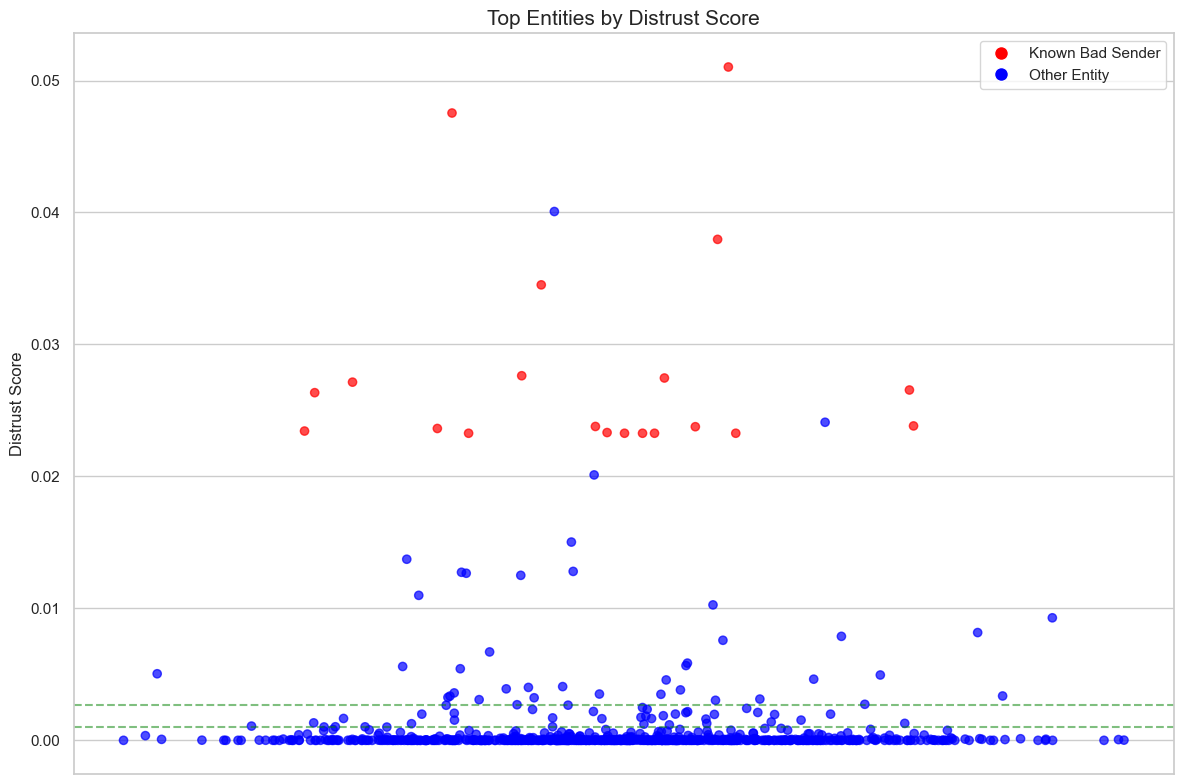

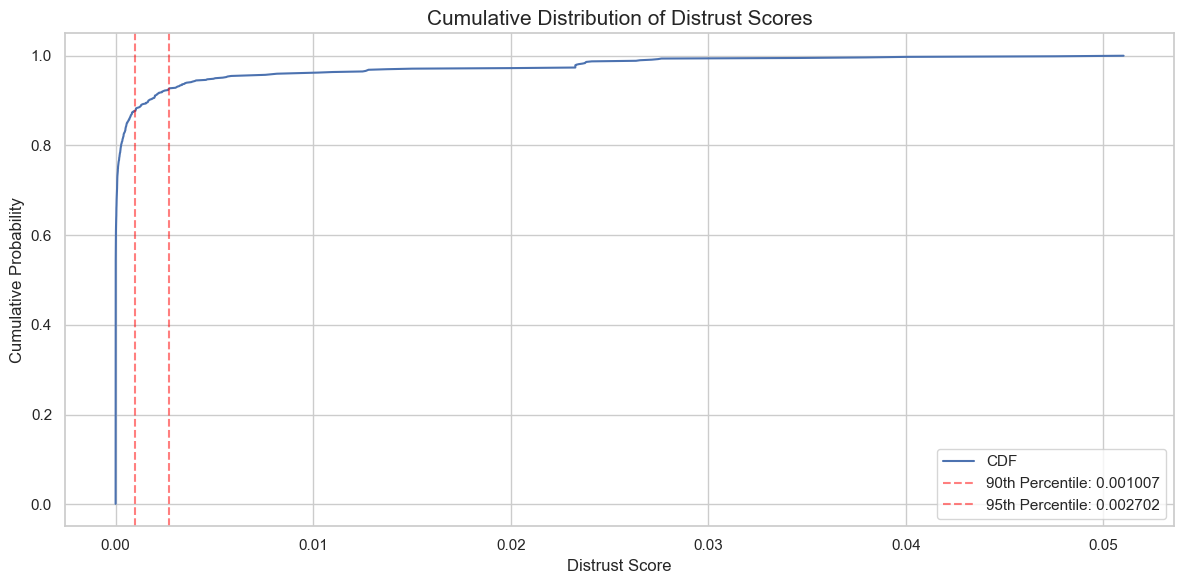

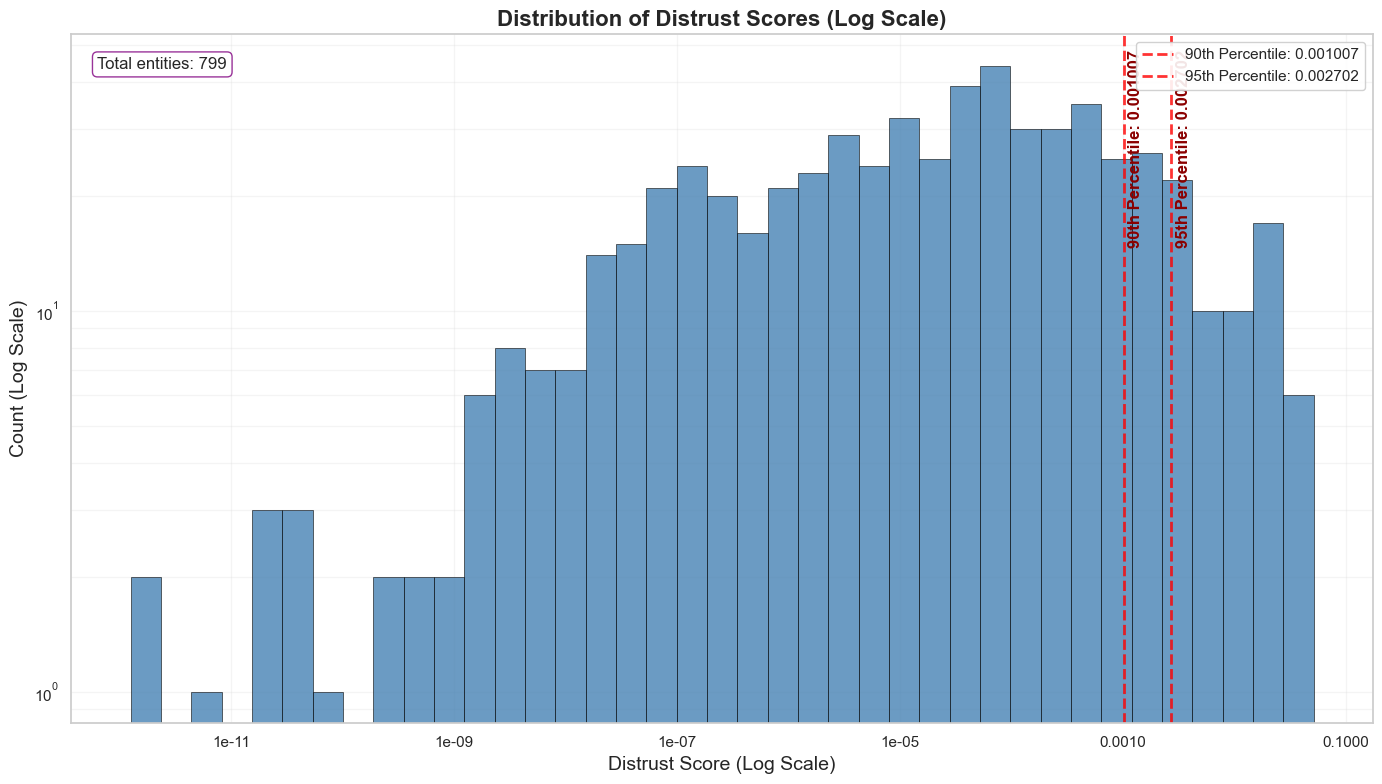

In [11]:
if __name__ == "__main__":
    main()